In [1]:
!pip install --upgrade scikit-learn  

In [2]:
## if the requirements were not already satisfied you have to restart the kernel

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import os
owd = os.getcwd()
os.chdir('../src/features')
import preprocess as pp
os.chdir(owd)
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
import statsmodels.api as sm

/Users/marinarosell/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [230]:
conn = sqlite3.connect('../src/data/td_V2.db')
git_commits = pd.read_sql_query("SELECT * FROM GIT_COMMITS",conn)
szz_fault_inducing_commits = pd.read_sql_query("SELECT * FROM szz_fault_inducing_commits",conn)
refactoring_miner = pd.read_sql_query("SELECT * FROM refactoring_miner",conn)
refactoring_miner = refactoring_miner[refactoring_miner["COMMIT_HASH"].isin(git_commits["COMMIT_HASH"])]
git_commits_changes = pd.read_sql_query("SELECT * FROM GIT_COMMITS_CHANGES", conn)
git_commits_changes = git_commits_changes[git_commits_changes["COMMIT_HASH"].isin(refactoring_miner["COMMIT_HASH"])]

In [4]:
print(len(refactoring_miner), len(szz_fault_inducing_commits))
clean_df = pp.preprocess(git_commits, szz_fault_inducing_commits, refactoring_miner, git_commits_changes)
clean_df = clean_df[clean_df["FAULT_INDUCING_COMMIT_HASH"].isin(szz_fault_inducing_commits["FAULT_INDUCING_COMMIT_HASH"])]
clean_df

32334 52428


/Users/marinarosell/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


ValueError: cannot convert float NaN to integer

In [8]:
git_commits.head()

,PROJECT_ID,COMMIT_HASH,COMMIT_MESSAGE,AUTHOR,AUTHOR_DATE,AUTHOR_TIMEZONE,COMMITTER,COMMITTER_DATE,COMMITTER_TIMEZONE,BRANCHES,IN_MAIN_BRANCH,MERGE,PARENTS
0,org.apache:archiva,94fe3a7fc056638c90cbe4a6319c3cb658f395a5,create template structure git-svn-id: https:...,Brett Porter,2005-11-23 23:54:12+00:00,0,Brett Porter,2005-11-23 23:54:12+00:00,0,{'master'},True,False,[]
1,org.apache:archiva,2b6be811c1d4f5e81339616208530d486608e42b,repository manager - root POM git-svn-id: ht...,Brett Porter,2005-11-28 03:15:35+00:00,0,Brett Porter,2005-11-28 03:15:35+00:00,0,{'master'},True,False,['94fe3a7fc056638c90cbe4a6319c3cb658f395a5']
2,org.apache:archiva,af0ddbcfc1e8c2528decbd458f42e16cbcae5051,update reports git-svn-id: https://svn.apach...,Brett Porter,2005-11-28 04:50:31+00:00,0,Brett Porter,2005-11-28 04:50:31+00:00,0,{'master'},True,False,['2b6be811c1d4f5e81339616208530d486608e42b']
3,org.apache:archiva,ea640e1803a8535ebfba2ade4ea9272b240067e8,move discovery to a new component PR: MRM-9 ...,Brett Porter,2005-11-29 01:34:22+00:00,0,Brett Porter,2005-11-29 01:34:22+00:00,0,{'master'},True,False,['af0ddbcfc1e8c2528decbd458f42e16cbcae5051']
4,org.apache:archiva,4b1232d671e7c0aa44927ce2d4574d8cb751497d,add discovery module PR: MRM-9 git-svn-id: h...,Brett Porter,2005-11-29 01:43:41+00:00,0,Brett Porter,2005-11-29 01:43:41+00:00,0,{'master'},True,False,['ea640e1803a8535ebfba2ade4ea9272b240067e8']


In [6]:
git_commits_changes.shape

(121645, 8)

In [168]:
git_commits['COMMITTER_DATE'] = pd.to_datetime(git_commits['COMMITTER_DATE'], errors='coerce')

In [199]:
git_commits['COMMITTER_DATE'] = pd.to_datetime(git_commits['COMMITTER_DATE'], errors='coerce')
first_commit = {}
for proj in git_commits.PROJECT_ID.unique().tolist():
    first_commit[proj] = pd.to_datetime(git_commits[git_commits.PROJECT_ID == proj]['COMMITTER_DATE'].min().replace(tzinfo=None)).date()
    
    

In [275]:
(first_commit['org.apache:archiva'] - pd.to_datetime('today').date()).days

-5813

In [216]:
git_commits['COMMITTER_DATE'].dtype

dtype('O')

In [280]:
data = git_commits.copy()
git_commits['commit_day'] = np.nan
for proj in git_commits.PROJECT_ID.unique().tolist():
    if proj in ['org.apache:batik','org.apache:cocoon','org.apache:felix','org.apache:santuario']:
        pass
    else:
        git_commits.loc[git_commits.PROJECT_ID == proj, 'COMMITTER_DATE'] = git_commits['COMMITTER_DATE'].apply(lambda x: str(x)[:-6])

    git_commits.loc[git_commits.PROJECT_ID == proj,'commit_day'] = pd.to_datetime(git_commits.loc[git_commits.PROJECT_ID == proj,'COMMITTER_DATE'], dayfirst=True).dt.date - first_commit[proj]
git_commits['commit_day'] = git_commits['commit_day'].apply(lambda x: x.days)
    

In [282]:
git_commits_changes

,PROJECT_ID,FILE,COMMIT_HASH,DATE,COMMITTER_ID,LINES_ADDED,LINES_REMOVED,NOTE
7569,org.apache:archiva,pom.xml,0314ca95cbd0580114688cb26179e47e7edb19a7,2007-03-22 21:12:12+00:00,Joakim Erdfelt,0,0,More directory moves git-svn-id: https://svn....
7570,org.apache:archiva,RepositoryArtifactIndex.java,0314ca95cbd0580114688cb26179e47e7edb19a7,2007-03-22 21:12:12+00:00,Joakim Erdfelt,0,0,More directory moves git-svn-id: https://svn....
7571,org.apache:archiva,RepositoryArtifactIndexFactory.java,0314ca95cbd0580114688cb26179e47e7edb19a7,2007-03-22 21:12:12+00:00,Joakim Erdfelt,0,0,More directory moves git-svn-id: https://svn....
7572,org.apache:archiva,RepositoryIndexException.java,0314ca95cbd0580114688cb26179e47e7edb19a7,2007-03-22 21:12:12+00:00,Joakim Erdfelt,0,0,More directory moves git-svn-id: https://svn....
7573,org.apache:archiva,RepositoryIndexSearchException.java,0314ca95cbd0580114688cb26179e47e7edb19a7,2007-03-22 21:12:12+00:00,Joakim Erdfelt,0,0,More directory moves git-svn-id: https://svn....
...,...,...,...,...,...,...,...,...
1142562,org.apache:santuario,.settings/org.eclipse.jdt.core.prefs,b91e5b0cf9c8fc7f26e831d402223220ce4dc847,2018-05-15 13:03:07+00:00,Colm O hEigeartaigh,1,0,SANTUARIO-487 - Allow users to set a SecurityE...
1142563,org.apache:santuario,src/main/java/org/apache/xml/security/stax/ext...,b91e5b0cf9c8fc7f26e831d402223220ce4dc847,2018-05-15 13:03:07+00:00,Colm O hEigeartaigh,27,7,SANTUARIO-487 - Allow users to set a SecurityE...
1142564,org.apache:santuario,src/main/java/org/apache/xml/security/stax/imp...,b91e5b0cf9c8fc7f26e831d402223220ce4dc847,2018-05-15 13:03:07+00:00,Colm O hEigeartaigh,14,4,SANTUARIO-487 - Allow users to set a SecurityE...
1142565,org.apache:santuario,src/main/java/org/apache/xml/security/stax/imp...,b91e5b0cf9c8fc7f26e831d402223220ce4dc847,2018-05-15 13:03:07+00:00,Colm O hEigeartaigh,3,2,SANTUARIO-487 - Allow users to set a SecurityE...


In [281]:
git_commits

,PROJECT_ID,COMMIT_HASH,COMMIT_MESSAGE,AUTHOR,AUTHOR_DATE,AUTHOR_TIMEZONE,COMMITTER,COMMITTER_DATE,COMMITTER_TIMEZONE,BRANCHES,IN_MAIN_BRANCH,MERGE,PARENTS,commit_day
0,org.apache:archiva,94fe3a7fc056638c90cbe4a6319c3cb658f395a5,create template structure git-svn-id: https:...,Brett Porter,2005-11-23 23:54:12+00:00,0,Brett Porter,2005-11-23 23:54:12,0,{'master'},True,False,[],0
1,org.apache:archiva,2b6be811c1d4f5e81339616208530d486608e42b,repository manager - root POM git-svn-id: ht...,Brett Porter,2005-11-28 03:15:35+00:00,0,Brett Porter,2005-11-28 03:15:35,0,{'master'},True,False,['94fe3a7fc056638c90cbe4a6319c3cb658f395a5'],5
2,org.apache:archiva,af0ddbcfc1e8c2528decbd458f42e16cbcae5051,update reports git-svn-id: https://svn.apach...,Brett Porter,2005-11-28 04:50:31+00:00,0,Brett Porter,2005-11-28 04:50:31,0,{'master'},True,False,['2b6be811c1d4f5e81339616208530d486608e42b'],5
3,org.apache:archiva,ea640e1803a8535ebfba2ade4ea9272b240067e8,move discovery to a new component PR: MRM-9 ...,Brett Porter,2005-11-29 01:34:22+00:00,0,Brett Porter,2005-11-29 01:34:22,0,{'master'},True,False,['af0ddbcfc1e8c2528decbd458f42e16cbcae5051'],6
4,org.apache:archiva,4b1232d671e7c0aa44927ce2d4574d8cb751497d,add discovery module PR: MRM-9 git-svn-id: h...,Brett Porter,2005-11-29 01:43:41+00:00,0,Brett Porter,2005-11-29 01:43:41,0,{'master'},True,False,['ea640e1803a8535ebfba2ade4ea9272b240067e8'],6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153989,org.apache:santuario,3bbe9d92b996fed10440ba772e1be711c183f781,Minor optimisation\n\ngit-svn-id: https://svn....,Colm O hEigeartaigh,2019-06-25T13:59:59Z,0,Colm O hEigeartaigh,2019-06-25T13:59:59Z,0,['trunk'],True,False,['0dd1dd24374d5fd24967cb964dbf785dc8113a41'],6479
153990,org.apache:santuario,0114371d12701f4358746d6e39d54efc48a2a332,Minor improvement to XMLUtils\n\ngit-svn-id: h...,Colm O hEigeartaigh,2019-07-11T14:50:10Z,0,Colm O hEigeartaigh,2019-07-11T14:50:10Z,0,['trunk'],True,False,['3bbe9d92b996fed10440ba772e1be711c183f781'],6495
153991,org.apache:santuario,c05467b72c02227ce64ca7000a670b6f1eb5bdf1,Updating some dependencies\n\ngit-svn-id: http...,Colm O hEigeartaigh,2019-07-12T08:12:52Z,0,Colm O hEigeartaigh,2019-07-12T08:12:52Z,0,['trunk'],True,False,['0114371d12701f4358746d6e39d54efc48a2a332'],6496
153992,org.apache:santuario,5aa25ac67d4e4efae605220f84935145827247e9,Removing XMLSignatureInput fallback\n\ngit-svn...,Colm O hEigeartaigh,2019-07-12T11:00:28Z,0,Colm O hEigeartaigh,2019-07-12T11:00:28Z,0,['trunk'],True,False,['c05467b72c02227ce64ca7000a670b6f1eb5bdf1'],6496


In [264]:
data['commit_day'] = data['commit_day'].days

AttributeError: 'Series' object has no attribute 'days'

In [169]:
#git_commits['commit_day'] = git_commits.apply(lambda x: x['COMMITTER_DATE'] - git_commits[git_commits.PROJECT_ID == x.PROJECT_ID]['COMMITTER_DATE'].min(), axis=1)



KeyboardInterrupt: 

In [7]:
git_commits.PROJECT_ID.value_counts()

org.apache:felix                 30470
org.apache:cocoon                26321
org.apache:hive                  15733
org.apache:archiva                8695
org.apache:batik                  7015
org.apache:cayenne                6733
org.apache:thrift                 6386
org.apache:santuario              5746
org.apache:collections            3616
org.apache:httpcore               3604
org.apache:configuration          3413
org.apache:commons-io             3374
org.apache:httpclient             3290
org.apache:vfs                    3074
org.apache:net                    2497
org.apache:dbcp                   2465
org.apache:zookeeper              2361
org.apache:digester               2192
org.apache:codec                  2144
org.apache:commons-jelly          1945
org.apache:commons-jexl           1927
org.apache:bcel                   1753
org.apache:validator              1548
org.apache:beanutils              1405
org.apache:daemon                 1251
org.apache:commons-fileup

In [254]:
data = git_commits[git_commits.PROJECT_ID == 'org.apache:archiva'][['COMMITTER_DATE']]
data['COMMITTER_DATE'] = data['COMMITTER_DATE'].apply(lambda x: x[:-6]) # comment or uncomment in function of if appear problems
data['COMMITTER_DATE'] = (pd.to_datetime(data['COMMITTER_DATE'], dayfirst=True).dt.to_period('M')).astype(str)
#data['COMMITTER_DATE'] = pd.to_datetime(data['COMMITTER_DATE'], dayfirst=True).dt.date

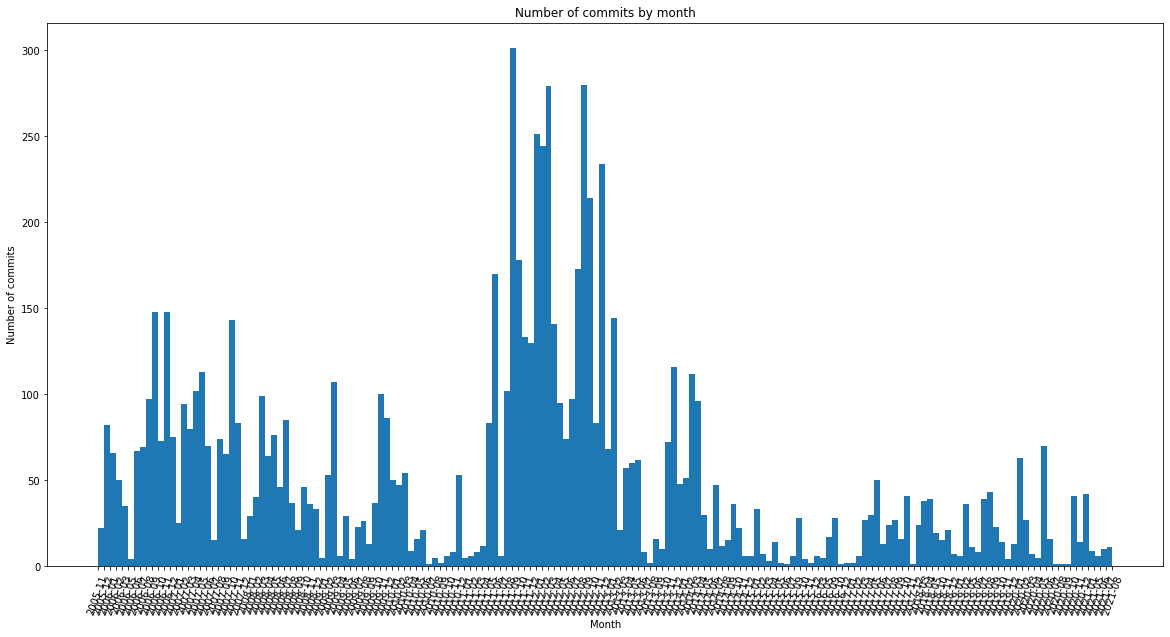

In [255]:
plt.figure(figsize=(20,10))
plt.hist(data['COMMITTER_DATE'], bins=len(data['COMMITTER_DATE'].unique()))
#plt.xticks(data[:1000]['COMMITTER_DATE'].unique(), rotation=70)
plt.xticks(rotation=70)
plt.title('Number of commits by month')
plt.ylabel('Number of commits')
plt.xlabel('Month')
plt.show()

In [6]:
(clean_df["FAULT_INDUCING_COMMIT_HASH"] == "30cff66e5efe6b99b7e7a2293061f0eea0def02f").sum()

12

In [7]:
szz_fault_inducing_commits[szz_fault_inducing_commits.FAULT_INDUCING_COMMIT_HASH == 'fc186f50392bf8c804b1d314971c92efa5f52fc3']

,PROJECT_ID,FAULT_FIXING_COMMIT_HASH,FAULT_INDUCING_COMMIT_HASH
4095,org.apache:cayenne,20616104fe25faaf014b23180fb8a40a6d93cbad,fc186f50392bf8c804b1d314971c92efa5f52fc3
4096,org.apache:cayenne,770a960d251b42dc323a87b2cdf4cef844777a31,fc186f50392bf8c804b1d314971c92efa5f52fc3
4097,org.apache:cayenne,6044e64c46033377d72c5cf1b3342b376df0cee7,fc186f50392bf8c804b1d314971c92efa5f52fc3
4101,org.apache:cayenne,5f364c585b9fc39e02d271747f30447c62030ab2,fc186f50392bf8c804b1d314971c92efa5f52fc3
4102,org.apache:cayenne,fa5f7734aa45a448463d44ec7474326f978710c1,fc186f50392bf8c804b1d314971c92efa5f52fc3
...,...,...,...
7039,org.apache:cayenne,9e6c27ba798839f5dd3e26f36e89b8bb8bc297d7,fc186f50392bf8c804b1d314971c92efa5f52fc3
7046,org.apache:cayenne,9b91f6d2a150d83918acf8999442f2bb120f2ce6,fc186f50392bf8c804b1d314971c92efa5f52fc3
7050,org.apache:cayenne,90c19b0c18614346eb110265da2780caaa84dc09,fc186f50392bf8c804b1d314971c92efa5f52fc3
7068,org.apache:cayenne,fa4bddd4c1f6081f4d4f604f5c19826416387244,fc186f50392bf8c804b1d314971c92efa5f52fc3


In [8]:
refactor_commits = refactoring_miner[["COMMIT_HASH", "REFACTORING_TYPE"]].merge(git_commits_changes[["COMMIT_HASH", "DATE", "COMMITTER_ID", "LINES_ADDED", "LINES_REMOVED"]], on = "COMMIT_HASH")
refactor_commits["LINES_ADDED"] = refactor_commits["LINES_ADDED"].astype(int)
refactor_commits["LINES_REMOVED"] = refactor_commits["LINES_REMOVED"].astype(int)
refactor_commits = refactor_commits.groupby(['COMMIT_HASH', 'COMMITTER_ID', 'REFACTORING_TYPE']).sum().reset_index()

In [9]:
inducing_ones = refactor_commits[refactor_commits["COMMIT_HASH"].isin(clean_df["FAULT_INDUCING_COMMIT_HASH"])]
refactor_commits["LABEL"] = np.where(refactor_commits["COMMIT_HASH"].isin(clean_df["FAULT_INDUCING_COMMIT_HASH"]), 1, 0)
y = refactor_commits["LABEL"]
X = refactor_commits.drop(columns = ["COMMIT_HASH","LABEL", "COMMITTER_ID"])
X["REFACTORING_TYPE"] = X["REFACTORING_TYPE"].astype("category").cat.codes

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf = svm.SVC(kernel = 'rbf')
clf.fit(X_train, y_train)
predicts = clf.predict(X_test)
confusion_matrix(y_test, predicts)

array([[2509,    2],
       [1016,    0]])

In [12]:
y_train = pd.Series(y_train).replace(1,0.95).replace(0,0.05)
y_train = np.asarray(y_train).astype(float)
model = sm.GLM(y_train,X_train, family = sm.families.Binomial())
res = model.fit()
res = res.predict(X_test)
confusion_matrix(y_test, res > 0.5)

array([[2505,    6],
       [1014,    2]])